In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [8]:
from src.utils import get_weeks
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[96:]
week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [9]:
print(week_labels)

[20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [14]:
%%time
train = pd.DataFrame()
for name in week_labels[:-2]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])
val = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-2]}_SVD_diffscount.feather')
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

CPU times: user 1min 22s, sys: 39.9 s, total: 2min 2s
Wall time: 2min 2s


## Fill nan

In [15]:
%%time
nan_cols = ['Subsector', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue']
train.fillna({x: '-999' for x in nan_cols}, inplace=True)
val.fillna({x: '-999' for x in nan_cols}, inplace=True)
test.fillna({x: '-999' for x in nan_cols}, inplace=True)

CPU times: user 6.11 s, sys: 2.55 s, total: 8.66 s
Wall time: 8.65 s


## Preprocessing

In [17]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'
with open(INTERIM/'num_cols.pkl', 'rb') as f:
    num_cols = pickle.load(f)
# num_cols = [c for c in train.columns \
#               if c not in id_cols + cat_cols and c != target_col]

### Label encode cat cols

In [18]:
%%time
# Label encode cats
from src.utils import to_cat_codes, apply_cats
to_cat_codes(train, cat_cols)
apply_cats(val, train)
apply_cats(test, train)

for col in cat_cols:
    train[col] = train[col].cat.codes
    val[col] = val[col].cat.codes
    test[col] = test[col].cat.codes

CPU times: user 23.3 s, sys: 5.33 s, total: 28.7 s
Wall time: 28.6 s


In [19]:
# Val has 1 OOF 
train['TickerIdx'] = train.TickerIdx + 1
val['TickerIdx'] = val.TickerIdx + 1
test['TickerIdx'] = test.TickerIdx + 1

### Scale num cols

In [20]:
%%time
# Scale conts
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pd.concat([train[num_cols], 
                                         val[num_cols], test[num_cols]]))

CPU times: user 6.62 s, sys: 8.32 s, total: 14.9 s
Wall time: 14.9 s


In [21]:
import pickle
with open(INTERIM/'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)

In [22]:
def scale_features(df, scaler, num_cols):
    scaled = scaler.transform(df[num_cols])
    for i, col in enumerate(num_cols):
        df[col] = scaled[:,i]

In [23]:
%%time
scale_features(train, scaler, num_cols)
scale_features(val, scaler, num_cols)
scale_features(test, scaler, num_cols)

CPU times: user 6.53 s, sys: 8.22 s, total: 14.8 s
Wall time: 14.7 s


In [27]:
%%time
train.reset_index(drop=True).to_feather(INTERIM/'nn_train.feather')
val.reset_index(drop=True).to_feather(INTERIM/'nn_val.feather')
test.reset_index(drop=True).to_feather(INTERIM/'nn_test.feather')

CPU times: user 4.91 s, sys: 6.05 s, total: 11 s
Wall time: 8.66 s


In [24]:
with open(INTERIM/'num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f, pickle.HIGHEST_PROTOCOL)

In [3]:
%%time
train = pd.read_feather(INTERIM/'nn_train.feather')
val = pd.read_feather(INTERIM/'nn_val.feather')
test = pd.read_feather(INTERIM/'nn_test.feather')

## Model

In [28]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [29]:
from src.neuralnet import TabularDataset
from torch.utils.data import DataLoader

In [30]:
%%time
train_ds = DataLoader(TabularDataset(train, cat_cols, num_cols, target_col), batch_size=128, shuffle=True)
val_ds = DataLoader(TabularDataset(val, cat_cols, num_cols, target_col), batch_size=128)
test_ds = DataLoader(TabularDataset(test, cat_cols, num_cols), batch_size=128)

CPU times: user 1.22 s, sys: 1.94 s, total: 3.15 s
Wall time: 3.14 s


In [31]:
%%time
import pickle
with open(INTERIM/'nn_train_ds.pkl', 'wb') as f:
    pickle.dump(train_ds, f, pickle.HIGHEST_PROTOCOL)
with open(INTERIM/'nn_val_ds.pkl', 'wb') as f:
    pickle.dump(val_ds, f, pickle.HIGHEST_PROTOCOL)
with open(INTERIM/'nn_test_ds.pkl', 'wb') as f:
    pickle.dump(test_ds, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.19 s, sys: 3.54 s, total: 4.73 s
Wall time: 4.95 s


In [32]:
cat_szs = [int(train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(50, (c+1)//2)) for c in cat_szs]

In [38]:
from src.neuralnet import NeuralNet, train_model

In [34]:
USE_CUDA = True

In [53]:
model = NeuralNet(emb_szs, n_cont=len(num_cols), emb_drop=0.04, 
                  szs=[1000, 500], drops=[0.001, 0.01], use_bn=True)

In [54]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [55]:
%%time
model, train_losses, val_losses, val_aucs = train_model(model, optimizer, criterion, 
                                train_ds, val_ds, n_epochs=2, USE_CUDA=USE_CUDA,
                                val_every=10)

Train Epoch: 1 [102400/8102750 (1%)]	Loss: 0.165683
Train Epoch: 1 [204800/8102750 (3%)]	Loss: 0.135655
Train Epoch: 1 [307200/8102750 (4%)]	Loss: 0.133301
Train Epoch: 1 [409600/8102750 (5%)]	Loss: 0.130748
Train Epoch: 1 [512000/8102750 (6%)]	Loss: 0.128504
Train Epoch: 1 [614400/8102750 (8%)]	Loss: 0.132721
Train Epoch: 1 [716800/8102750 (9%)]	Loss: 0.131821
Train Epoch: 1 [819200/8102750 (10%)]	Loss: 0.133663
Train Epoch: 1 [921600/8102750 (11%)]	Loss: 0.130020
Train Epoch: 1 [1024000/8102750 (13%)]	Loss: 0.128943
[0/493590 (0%)]
[102400/493590 (21%)]
[204800/493590 (41%)]
[307200/493590 (62%)]
[409600/493590 (83%)]
ROC AUC Score: 0.831971
Validation Loss: 0.130021
Train Epoch: 1 [1126400/8102750 (14%)]	Loss: 0.129809
Train Epoch: 1 [1228800/8102750 (15%)]	Loss: 0.129248
Train Epoch: 1 [1331200/8102750 (16%)]	Loss: 0.129193
Train Epoch: 1 [1433600/8102750 (18%)]	Loss: 0.128488
Train Epoch: 1 [1536000/8102750 (19%)]	Loss: 0.131956
Train Epoch: 1 [1638400/8102750 (20%)]	Loss: 0.12590

In [56]:
train_losses = pd.Series(train_losses)
val_losses = pd.Series(val_losses)
val_aucs = pd.Series(val_aucs)

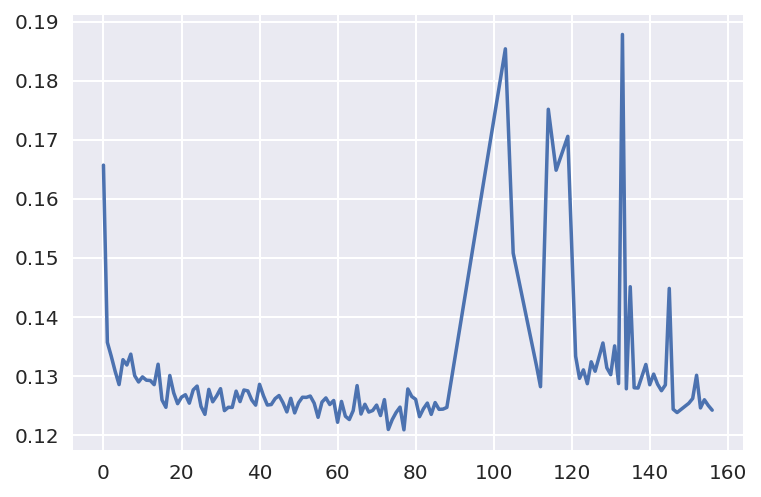

In [61]:
train_losses[train_losses<0.2].plot()

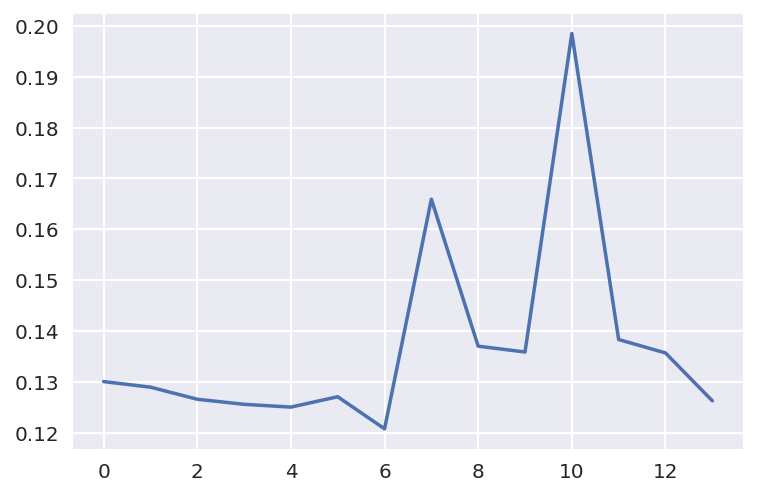

In [63]:
val_losses.plot()

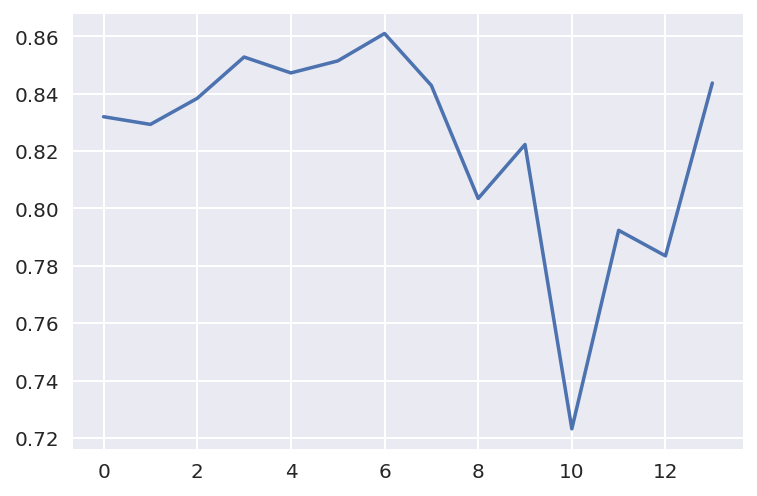

In [62]:
val_aucs.plot()

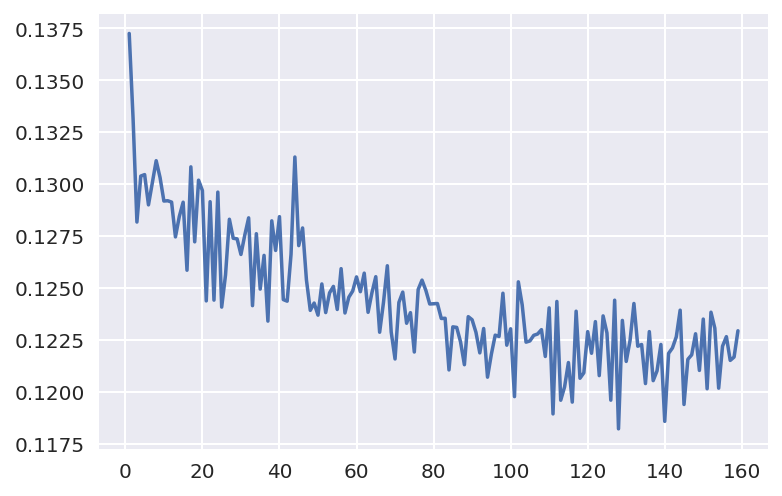

In [44]:
train_losses[train_losses > 0.1].plot()

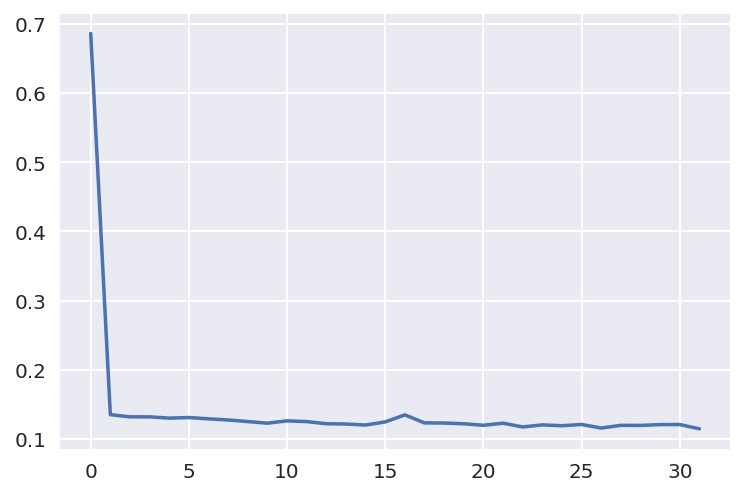

In [45]:
val_losses[val_losses > 0.1].plot()